In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
import optuna
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Timestamp

from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf, stationarity_test_kpss, stationarity_test_adf

from time_series_model.data.weather.weather_dataloader import MeteostatDataLoader
from time_series_model.data.data_loading import SMARDDataLoader
from time_series_model.evaluation_method import get_covariate_args, cross_validation_without_refit

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("time_series_model").setLevel(logging.INFO)
logging.getLogger('lightning').setLevel(0)
logging.getLogger('pytorch_lightning').setLevel(0)
logging.getLogger('darts').setLevel(0)
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

### Load SMARD data

In [4]:
smard_dataloader = SMARDDataLoader(
    file_paths=[
        os.path.join(os.getcwd(), os.pardir, 'data', 'raw', '2015_2016.csv'),
        os.path.join(os.getcwd(), os.pardir, 'data', 'raw', '2017_2018.csv'),
        os.path.join(os.getcwd(), os.pardir, 'data', 'raw', '2019_2020.csv'),
        os.path.join(os.getcwd(), os.pardir, 'data', 'raw', '2021_2022.csv'),
        os.path.join(os.getcwd(), os.pardir, 'data', 'raw', '2022_2023.csv')
    ]
)
smard_dataloader.load_data()
smard_dataloader.preprocess_data()
smard_dataloader.validate_data()

smard_data_df: DataFrame = smard_dataloader.data
smard_data_df['timestamp'] = pd.to_datetime(smard_data_df['timestamp'])
smard_data_df = smard_data_df.set_index('timestamp')
smard_data = TimeSeries.from_dataframe(
    smard_data_df, 
    value_cols=list(smard_data_df.columns), 
    fill_missing_dates=True, 
    fillna_value=0, 
    freq='1H'
)

2023-12-18 09:51:12,369 - time_series_model.data.data_loading - INFO - Initiating data loading process...
2023-12-18 09:51:12,833 - time_series_model.data.data_loading - INFO - Data loaded with 86448 rows and 15 columns.
2023-12-18 09:51:12,834 - time_series_model.data.data_loading - INFO - Data loading process completed successfully.
2023-12-18 09:51:12,836 - time_series_model.data.data_loading - INFO - Starting data preprocessing operations...
2023-12-18 09:51:12,837 - time_series_model.data.data_loading - INFO - Converting 'Datum' column to datetime format...
2023-12-18 09:51:13,785 - time_series_model.data.data_loading - INFO - Converted energy columns to float.
2023-12-18 09:51:14,106 - time_series_model.data.data_loading - INFO - Initial missing values in each column:
timestamp                  0
biomass_mwh               26
hydropower_mwh            26
wind_offshore_mwh         26
wind_onshore_mwh          26
photovoltaic_mwh          26
other_renewables_mwh      26
nuclear_mwh 

### probe order of differencing

biomass_mwh...


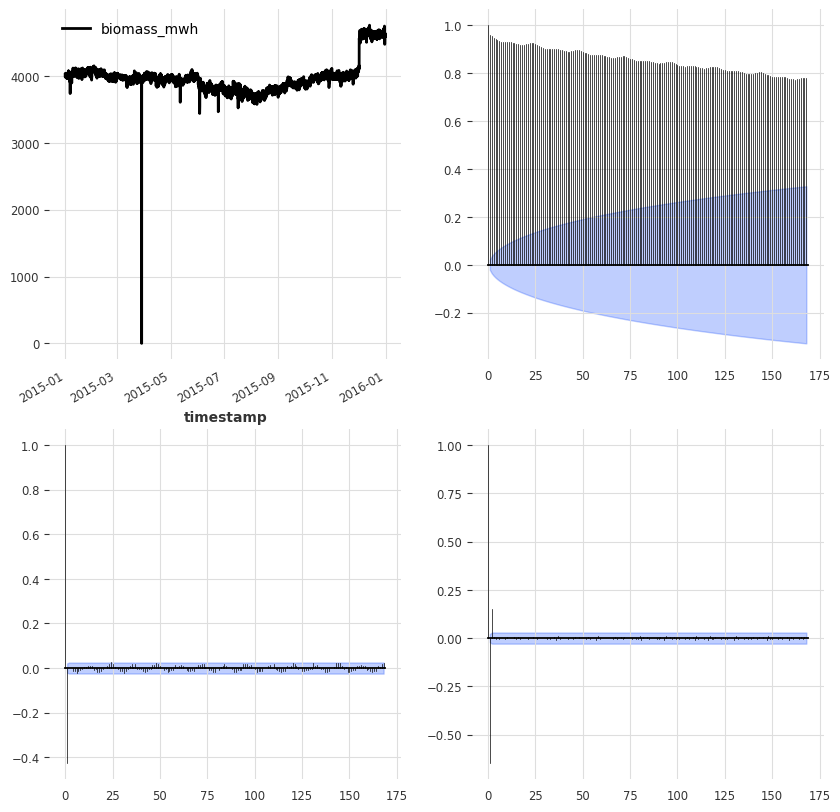

hydropower_mwh...


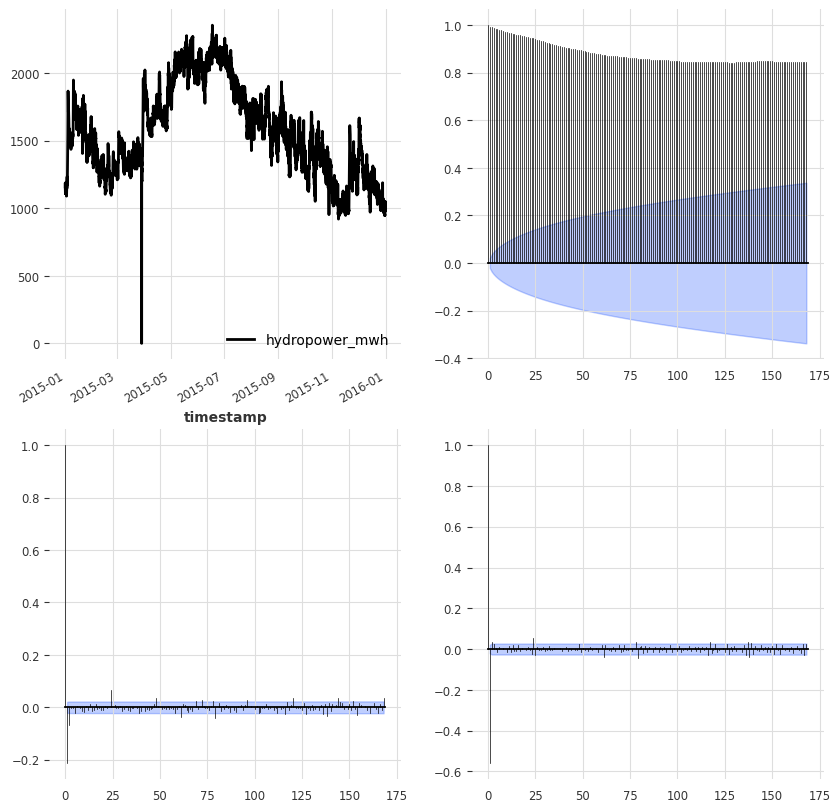

wind_offshore_mwh...


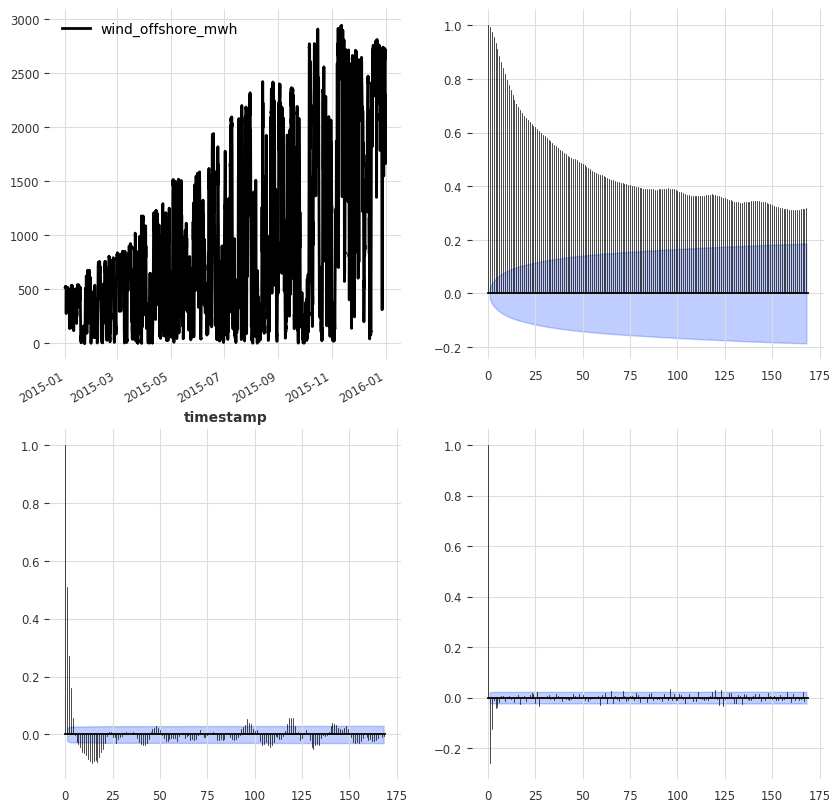

wind_onshore_mwh...


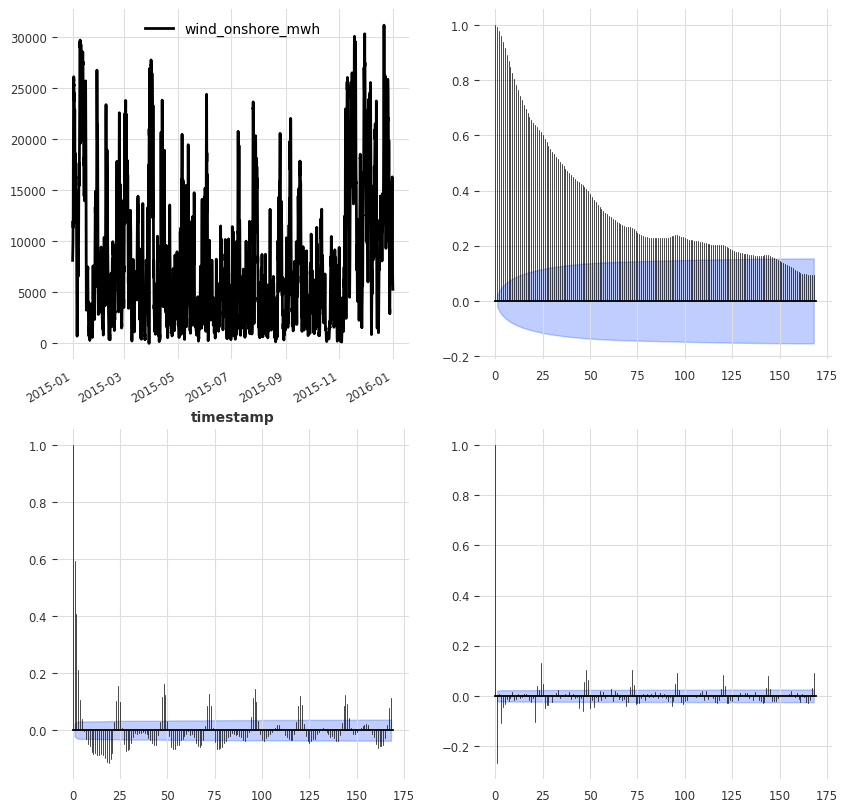

photovoltaic_mwh...


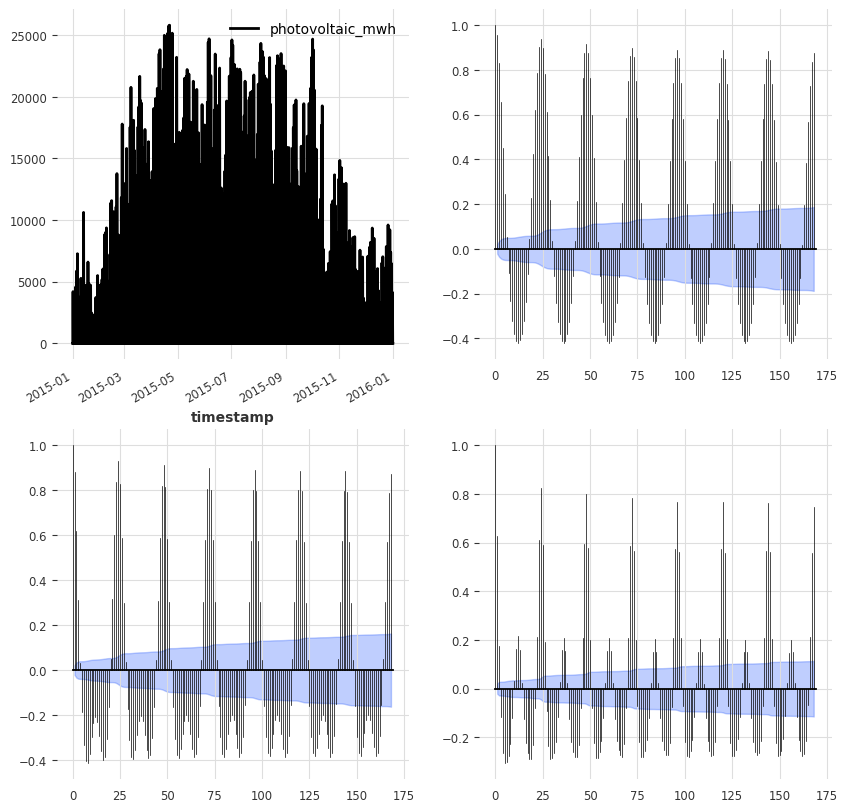

other_renewables_mwh...


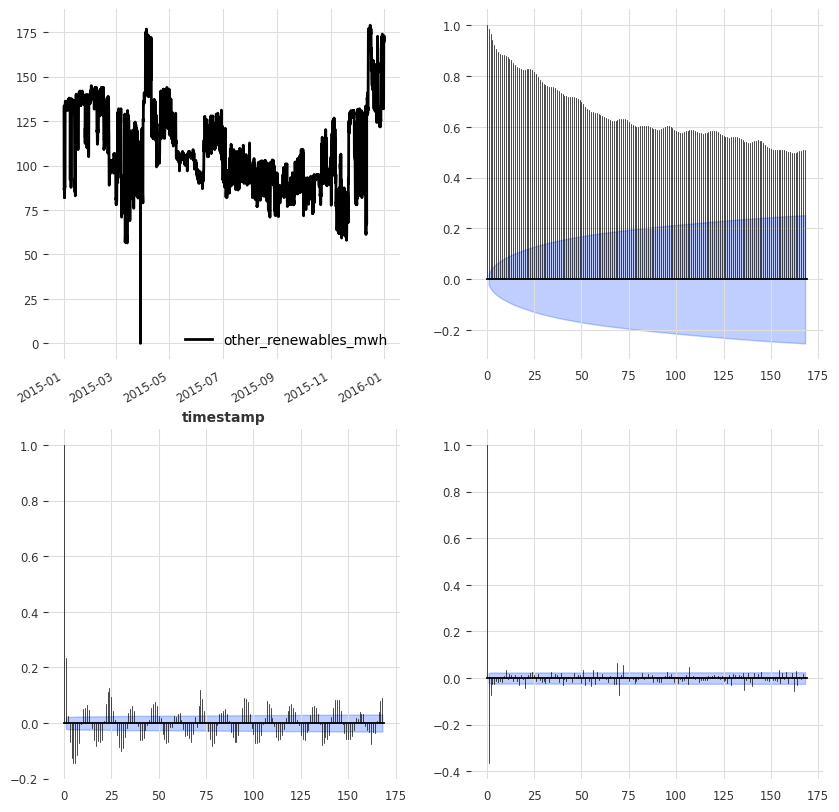

nuclear_mwh...


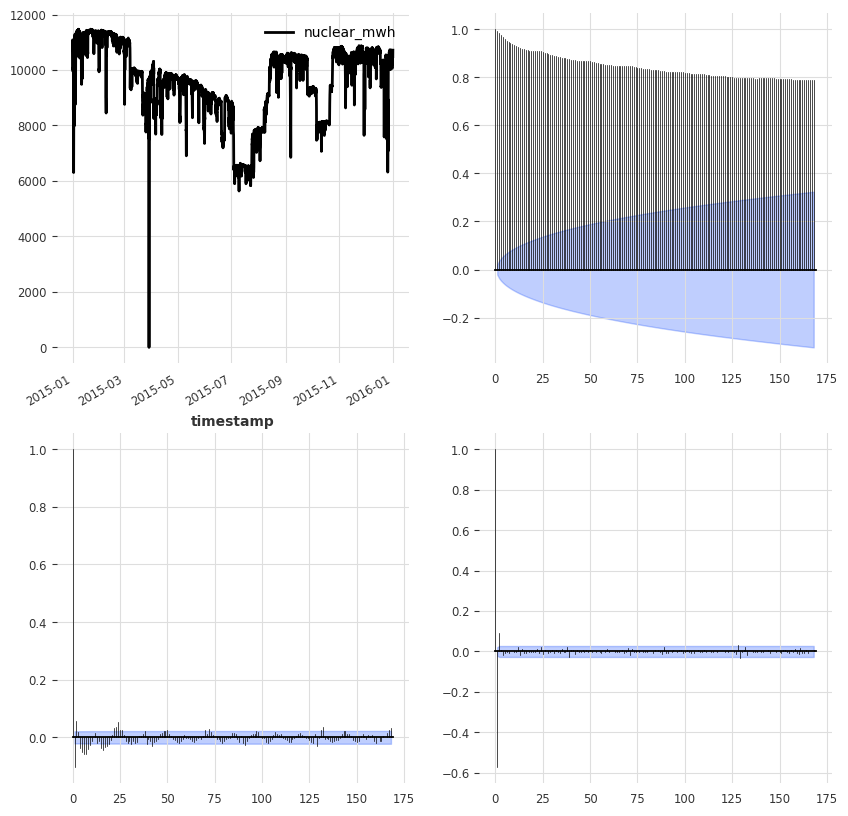

brown_coal_mwh...


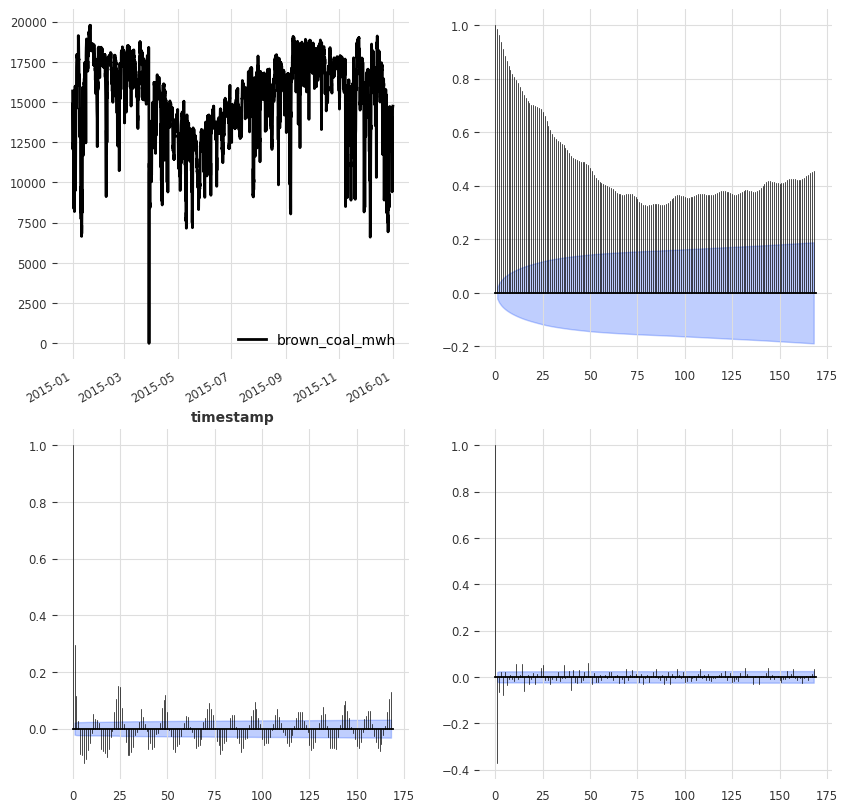

hard_coal_mwh...


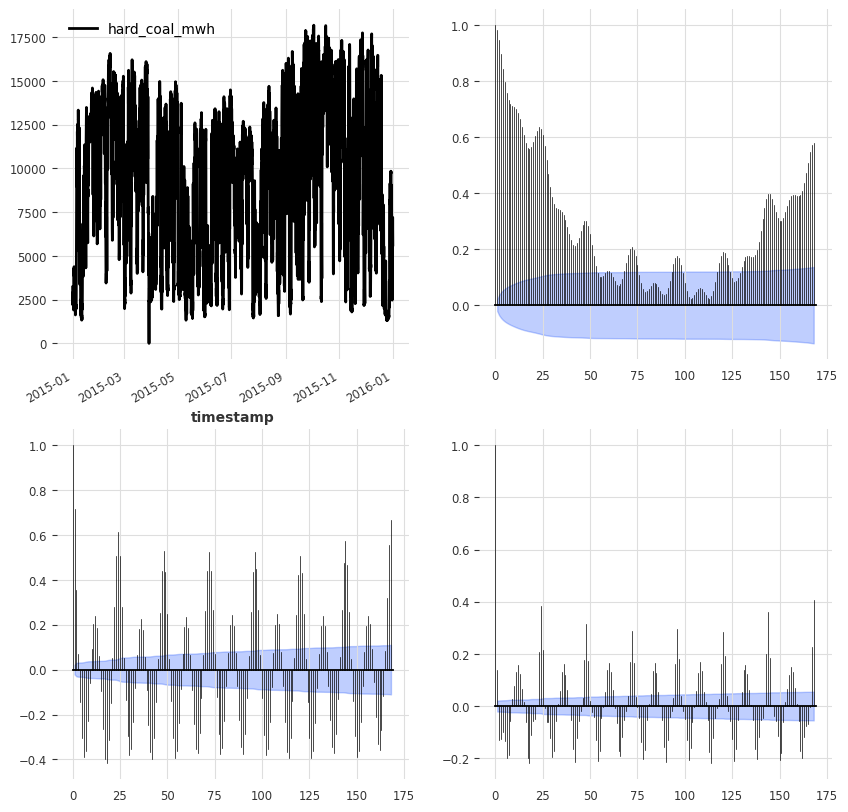

natural_gas_mwh...


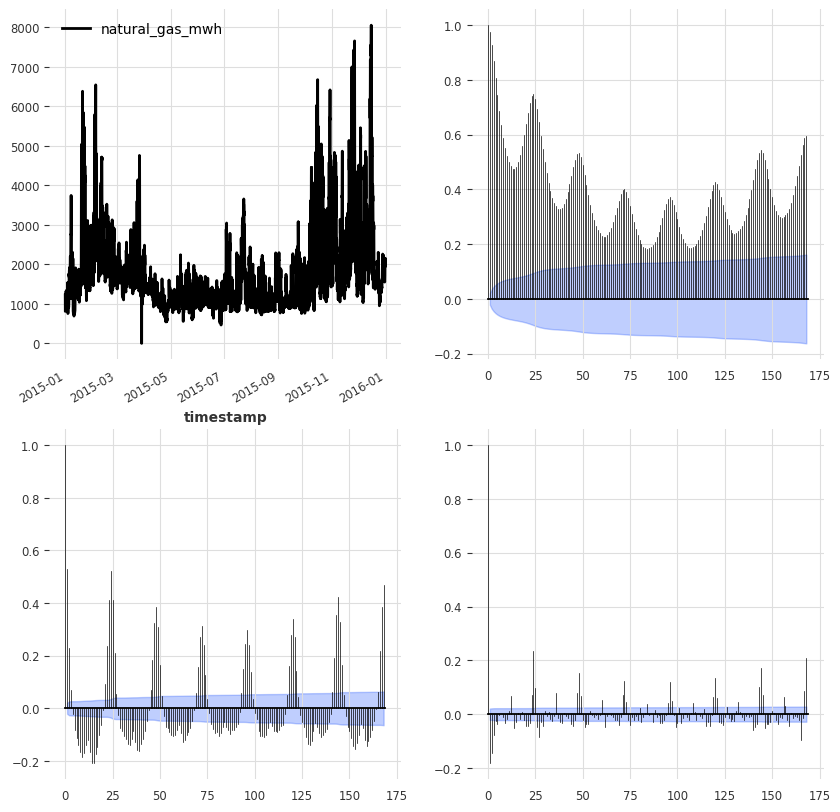

pumped_storage_mwh...


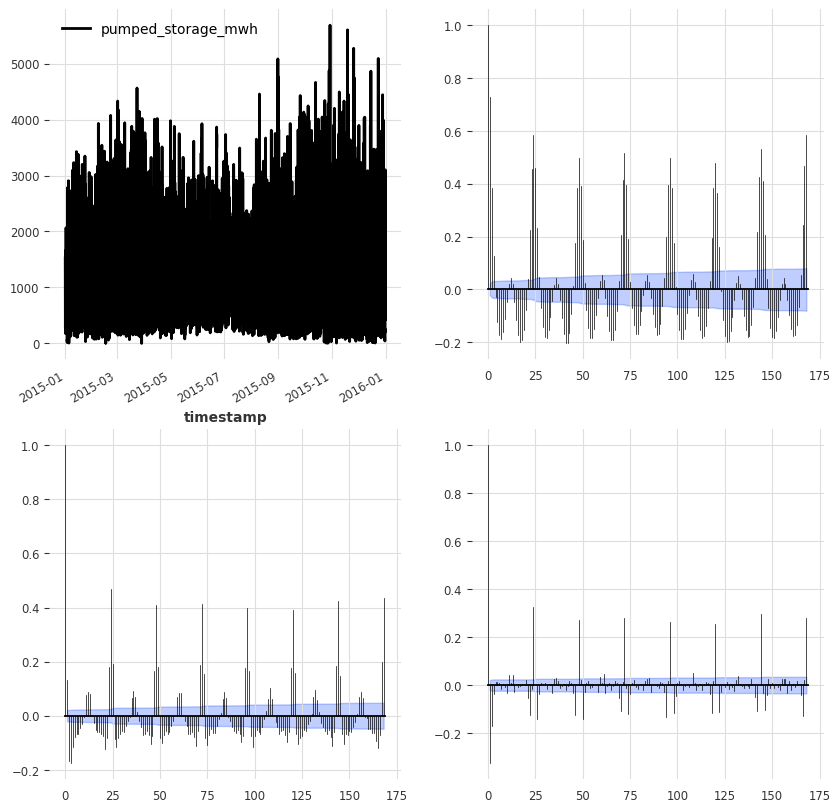

other_conventional_mwh...


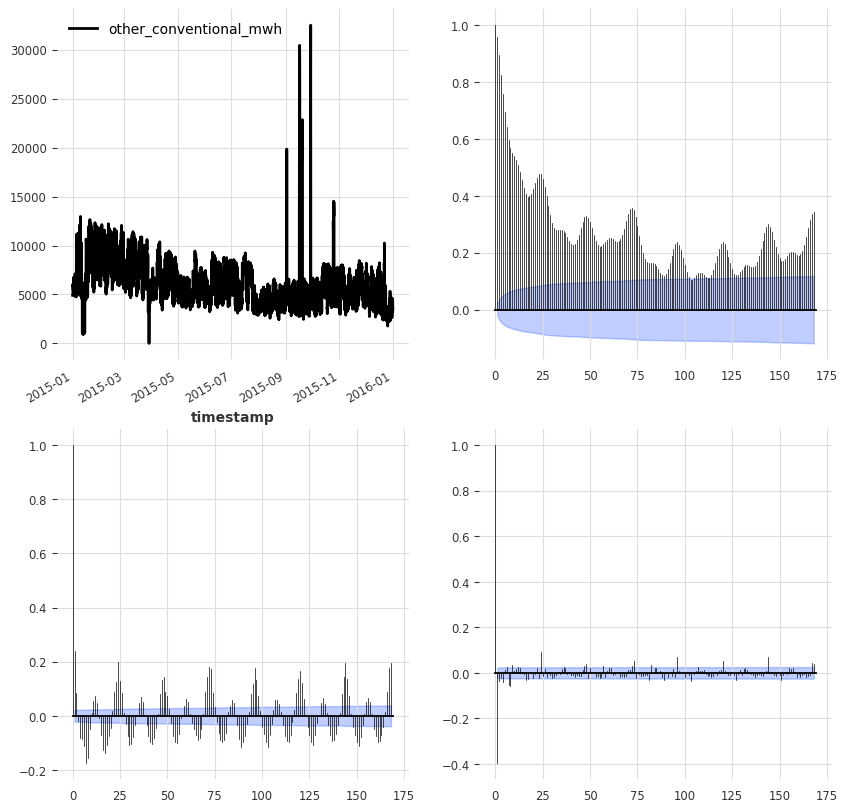

In [12]:
for resource in smard_data.columns:
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    print(f'{resource}...')
    first_n_samples = 24*365
    max_lag = 7*24
    smard_data[resource].head(first_n_samples).plot(ax=axs[0, 0])
    plot_acf(smard_data[resource].head(first_n_samples), axis=axs[0, 1], max_lag=max_lag)
    plot_acf(smard_data[resource].head(first_n_samples).diff(), axis=axs[1, 0], max_lag=max_lag)
    plot_acf(smard_data[resource].head(first_n_samples).diff(n=2), axis=axs[1, 1], max_lag=max_lag)
    plt.show()

In [9]:
smard_data_df.head(n=24*7*15)

,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaic_mwh,other_renewables_mwh,nuclear_mwh,brown_coal_mwh,hard_coal_mwh,natural_gas_mwh,pumped_storage_mwh,other_conventional_mwh
timestamp,,,,,,,,,,,,
2015-01-01 00:00:00,4024.25,1158.25,516.50,8128.00,0.0,133.00,10710.50,15687.25,3219.75,1226.25,1525.75,4909.25
2015-01-01 01:00:00,3982.75,1188.00,516.25,8297.50,0.0,122.50,11086.25,15321.75,2351.25,870.75,1079.25,4932.75
2015-01-01 02:00:00,4019.50,1139.25,514.00,8540.00,0.0,93.00,11026.25,14817.50,2227.00,809.50,787.00,5041.75
2015-01-01 03:00:00,4040.75,1122.50,517.75,8552.00,0.0,86.50,11027.75,14075.00,2339.75,821.00,287.75,5084.00
2015-01-01 04:00:00,4037.75,1112.00,519.75,8643.50,0.0,86.50,10962.25,14115.00,2461.50,831.25,346.75,5070.75
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-15 20:00:00,3965.75,1747.00,843.75,11582.00,40.0,117.00,9713.00,14619.00,10292.25,1541.50,4018.75,5954.75
2015-04-15 21:00:00,3936.50,1720.25,769.25,10975.25,0.0,117.50,9719.50,15044.50,10713.00,1319.00,2823.75,5678.75
2015-04-15 22:00:00,3937.00,1684.25,799.50,10570.75,0.0,117.25,9740.75,15403.75,10279.50,1149.00,1288.25,5281.25


In [22]:
for resource in smard_data.columns:
    print(f'{resource}')
    print(f'Results by {stationarity_test_adf.__name__}')
    print(f'\t without differencing...')
    print(stationarity_test_adf(smard_data[resource].head(size=24*7)))
    print(f'\t with differencing...')
    print(stationarity_test_adf(smard_data[resource].head(size=24*7).diff(n=1)))

biomass_mwh
Results by stationarity_test_adf
	 without differencing...
(-2.373981252323555, 0.1492150556574915, 13, 154, {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}, 1419.470206067183)
	 with differencing...
(-4.948705407113283, 2.800987403724645e-05, 14, 152, {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}, 1412.9306974461972)
hydropower_mwh
Results by stationarity_test_adf
	 without differencing...
(-1.6562674699557558, 0.4537738381816313, 3, 164, {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}, 1401.9259859875951)
	 with differencing...
(-4.671535618260842, 9.514756328167272e-05, 2, 164, {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}, 1394.321313919236)
wind_offshore_mwh
Results by stationarity_test_adf
	 without differencing...
(-2.4095190752036633, 0.1390677252582404, 1, 166, {'1%': -3.4703698981001665, '5%': -2.8791138497902193, '10%': -2.5761394077514

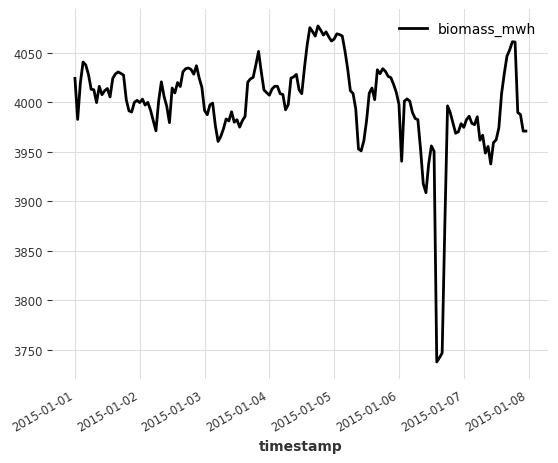

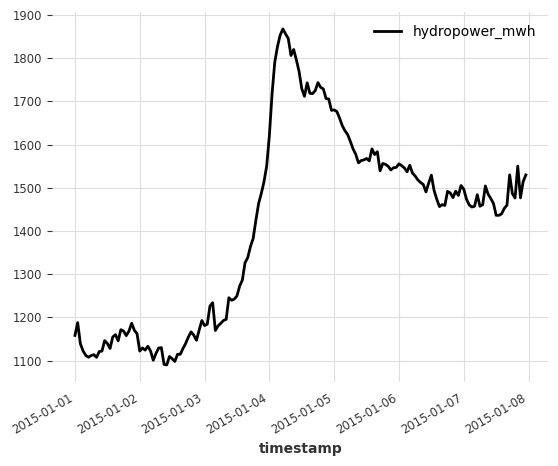

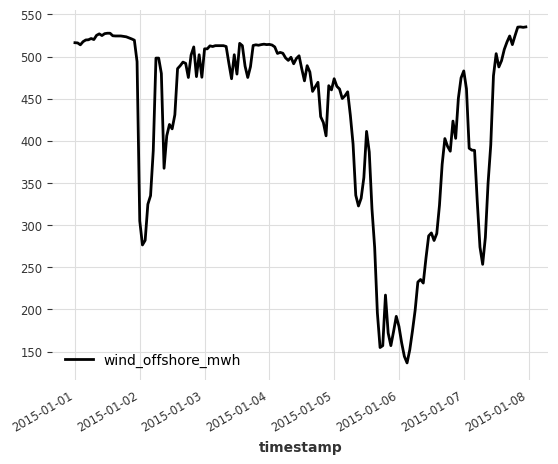

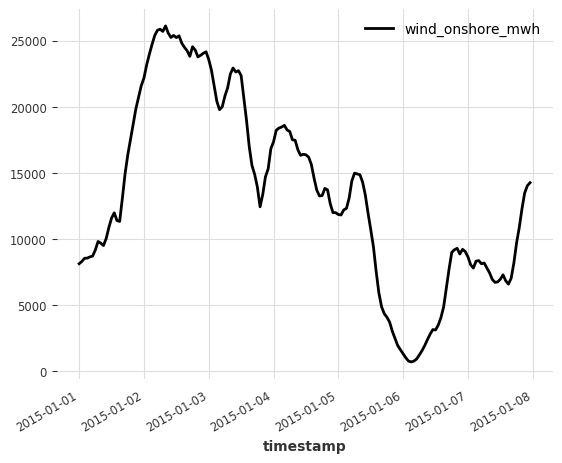

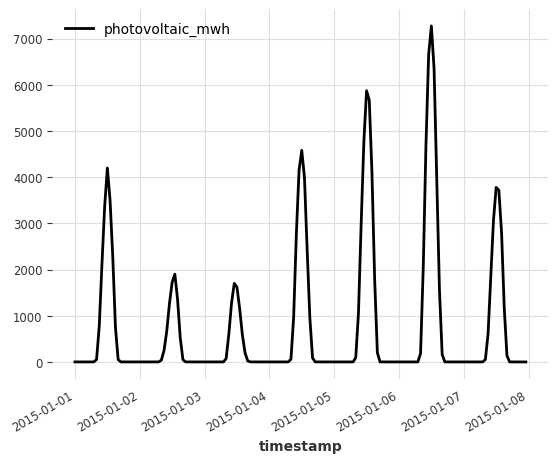

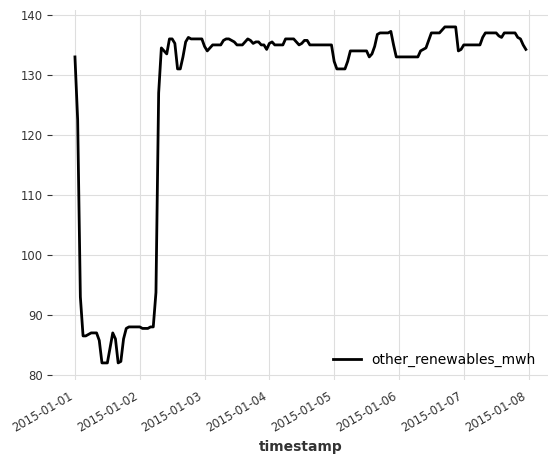

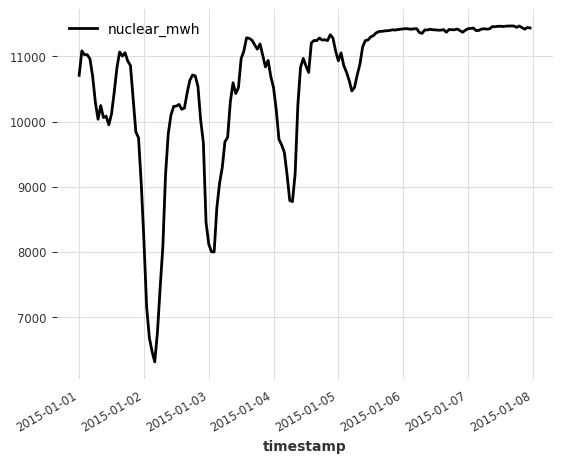

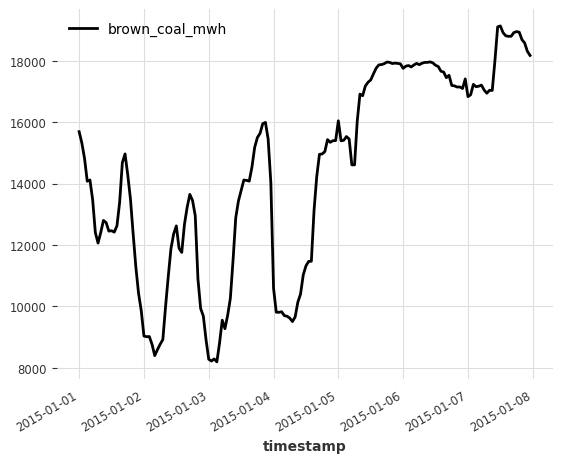

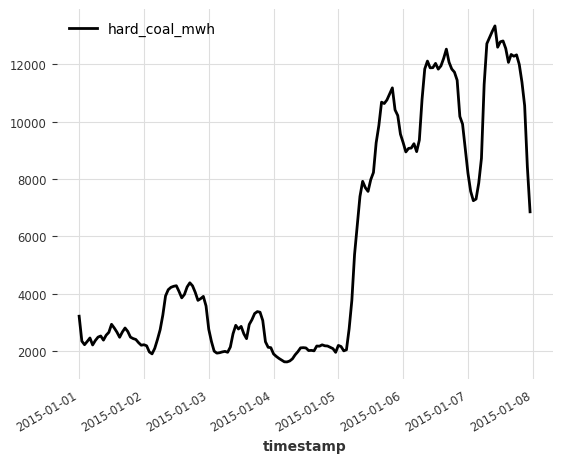

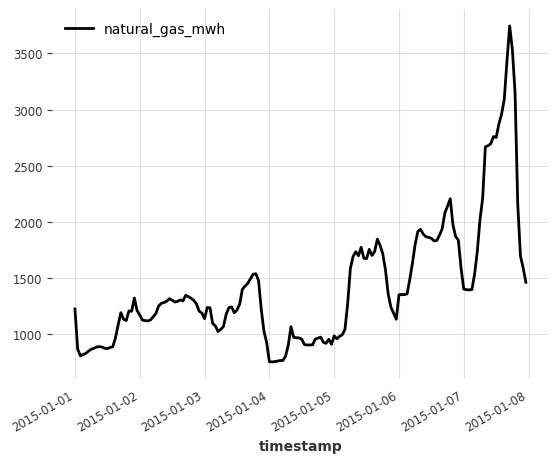

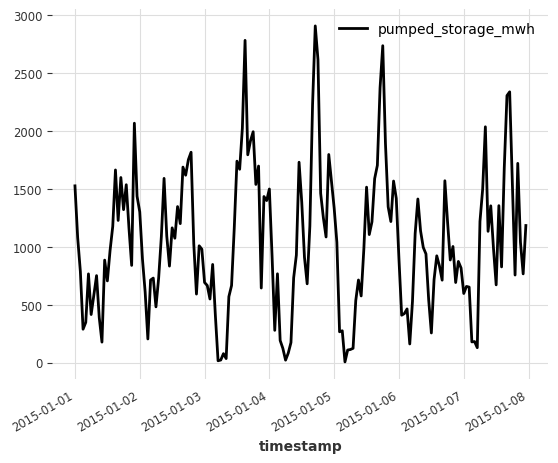

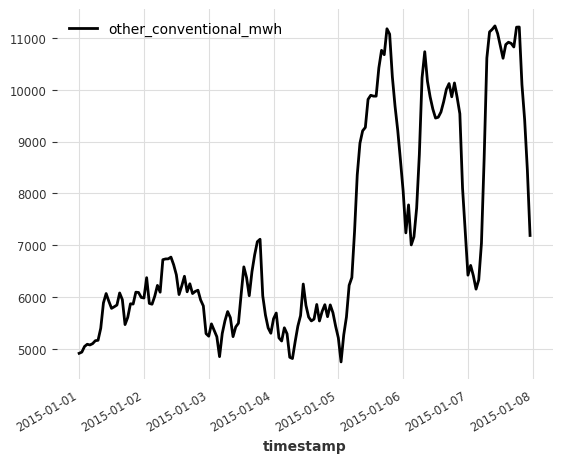

In [24]:
for resource in smard_data.columns:
    smard_data[resource].head(size=24*7).plot(label=resource)
    plt.show()